In [1]:
#!pip install yellowbrick
#!pip install kmodes

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import os
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline

In [3]:
os.getcwd()
#os.chdir('C:\\Users\\IMEN\\Documents\\openclassroom\\formation openclassrooms\\projet5')

'C:\\Users\\IMEN\\Documents\\openclassroom\\formation openclassrooms\\projet5'

In [4]:
def felbow_kprototypes(k_rng,data,index_categ_feat):
    #Elbow technique
    cost = [] 
    for cluster in k_rng: 
        print('{cluster}\.cluster start'.format(cluster=cluster))
        kproto = KPrototypes(n_clusters = cluster, init='Huang',n_jobs=-1,n_init=10,verbose=1)
        kproto.fit(data, categorical=[index_categ_feat])
        cost.append(kproto.cost_)
      
    plt.plot(k_rng,cost)
    plt.xlabel('Number of clusters')
    plt.ylabel('Cost')

In [5]:
def felbow(k_rng,data):
    #Elbow technique
    wcss = [] 
    for i in k_rng: 
        model = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        model.fit(data) 
        wcss.append(model.inertia_)
    plt.plot(k_rng,wcss)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')

In [6]:
def fsilhouette(k_rng,data):
    #Silhouette technique
    sse_ = []
    for k in k_rng:
        kmeans = KMeans(n_clusters=k,init = 'k-means++', random_state = 42).fit(data)
        sse_.append([k, silhouette_score(data, kmeans.labels_)])
    plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

In [7]:
def mean_clus_feat(df,group,feat):
    df_mean=pd.DataFrame(df.groupby(group)[feat].mean()).rename(columns={feat:feat+'_mean'})
    return df_mean

In [8]:
def fnb_customper_cluster(df):
    customer_per_cluster=pd.DataFrame(df.groupby('ClusterID')['CustomerID'].count())\
                .rename(columns={'CustomerID':'nb_customers'}).reset_index()
    return(customer_per_cluster)

In [9]:
def fpairplot(df,lists,title):
    fig = plt.figure(constrained_layout = True,figsize = (20,5))
    
    gs = GridSpec(1, 3, figure=fig) 
    #"Recency", "Frequency", "Monetary"
    #lists=[["Recency", "Frequency"],["Recency","Monetary"],["Frequency","Monetary"]]
    i=0
    for c in lists:      
        plt.subplot(gs[0,i])
        sns.scatterplot(data=df,x=c[0],y=c[1]).set(title=title) 
        i= i+1

### 1.Description des données

In [10]:
df_cmd=pd.read_csv('commandes_dataset.csv')
df_geo=pd.read_csv('geolocalisation_dataset.csv')
RFM=pd.read_csv('df_rfm.csv')

In [11]:
RFM.isna().sum()

customer_unique_id    0
Frequency             0
Recency               0
Monetary              0
dtype: int64

In [12]:
df_cmd.isna().sum()

customer_id                 0
customer_unique_id          0
customer_city               0
customer_state              0
order_id                    0
order_status                0
order_purchase_timestamp    0
order_item_id               0
product_id                  0
seller_id                   0
price                       0
payment_type                0
review_id                   0
review_score                0
product_category_name       0
seller_zip_code_prefix      0
seller_city                 0
seller_state                0
dtype: int64

### 3.Clustering avec kmeans (RFM)

In [13]:
X=RFM[['Frequency', 'Recency', 'Monetary']]
# Scaling input using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xstd = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [14]:
k_rng=range(2, 11)

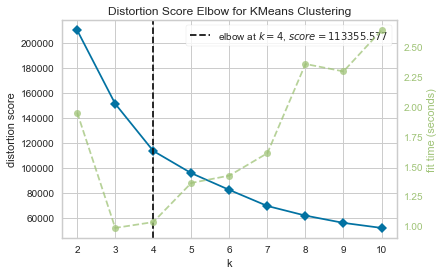

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# Instantiate the clustering model and visualizer
model = KMeans(init = 'k-means++', random_state = 42)
visualizer = KElbowVisualizer(model, k=k_rng)

visualizer.fit(Xstd)    # Fit the data to the visualizer
visualizer.poof()

**Remarque**<br>
-le silhouette score est entre - et 1<br>
-score proche de 1==>les points du meme cluster sont très similaire<br>
-score proche de -1==>les points du meme cluster ne sont très similaire


In [16]:
#Instantiate the clustering model and visualizer 
#model = KMeans(4)
#visualizer = SilhouetteVisualizer(model)

#visualizer.fit(Xstd)    # Fit the data to the visualizer
#visualizer.poof()

In [17]:
#pour k=4
kmeans = KMeans(n_clusters = 4, init = "k-means++", random_state = 42)
y_kmeans = kmeans.fit_predict(Xstd)
y_kmeans

array([0, 0, 1, ..., 1, 0, 1])

In [18]:
# k_selcted=4
# silhouette_avg = silhouette_score(Xstd, y_kmeans)
# print("For n_clusters =",
#         k_selcted,
#         "The average silhouette_score is :",
#         silhouette_avg,
#     )

In [19]:
RFM.shape

(91478, 4)

For n_clusters = 4 The average silhouette_score is : 0.43179645876872036

In [20]:
RFM_km=pd.concat([RFM, pd.Series(y_kmeans)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency',  'Recency','Monetary', 'ClusterID']
RFM_km

,CustomerID,Frequency,Recency,Monetary,ClusterID
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90,0
2,0000f46a3911fa3c0805444483337064,1,537,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00,1
...,...,...,...,...,...
91473,fffcf5a5ff07b0908bd4e2dbc735a684,2,447,1570.00,2
91474,fffea47cd6d3cc0a88bd621562a9d061,1,262,64.89,1
91475,ffff371b4d645b6ecea244b27531430a,1,568,89.90,1
91476,ffff5962728ec6157033ef9805bacc48,1,119,115.00,0


In [21]:
customer_per_cluster1=fnb_customper_cluster(RFM_km)
customer_per_cluster1

,ClusterID,nb_customers
0,0,49657
1,1,36679
2,2,2053
3,3,3089


In [22]:
RFM_km.describe()

,Frequency,Recency,Monetary,ClusterID
count,91478.000000,91478.000000,91478.000000,91478.000000
mean,1.211712,237.047662,144.949038,0.547148
std,0.679484,152.560470,220.997009,0.703757
min,1.000000,1.000000,0.850000,0.000000
25%,1.000000,114.000000,48.900000,0.000000
50%,1.000000,218.000000,89.900000,0.000000
75%,1.000000,345.000000,159.000000,1.000000
max,24.000000,695.000000,13440.000000,3.000000


**Obserrvations**<br>
le cluster 1 contient le plus de clients
    

<AxesSubplot:title={'center':'Recency'}, xlabel='ClusterID'>

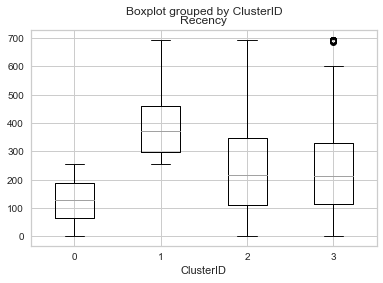

In [23]:

RFM_km.boxplot(column = 'Recency', by = 'ClusterID')

**Observations**<br>
Pour la récence, que le cluster 0 contient des outliers.<br>
cluster0:client les moins récents<br>
cluster1:clients les plus récents

<AxesSubplot:title={'center':'Monetary'}, xlabel='ClusterID'>

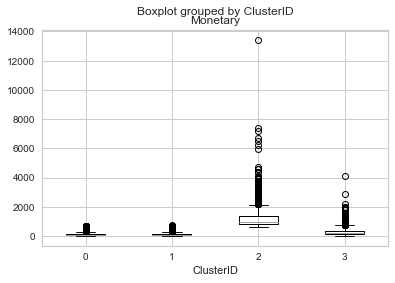

In [24]:
RFM_km.boxplot(column = 'Monetary', by = 'ClusterID')

**Observations**<br>
Pour les montants,le troisieme cluster(2) ont les montants les plus élevés. 

<AxesSubplot:title={'center':'Frequency'}, xlabel='ClusterID'>

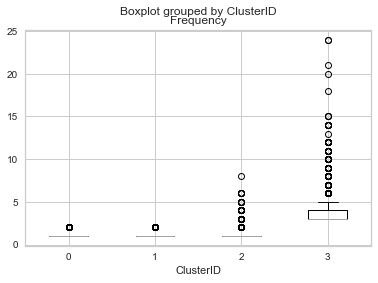

In [25]:
RFM_km.boxplot(column = 'Frequency', by = 'ClusterID')

In [26]:
RFM_km[RFM_km.ClusterID==2]['Frequency'].unique()

array([1, 2, 3, 6, 8, 4, 5], dtype=int64)

**Observations**<br>
-le cluster1 contient que les clienst qui ont achétes peu de fois (1,2)<br>
-le cluster2 contient que les clienst qui ont achétes peu de fois (1,2)<br>
-le cluster3 contient que les clienst qui ont achétes peu de fois (1, 2, 3, 6, 8, 4, 5)<br>
-le cluster4 contient que les clienst qui ont achétes entre 4 et 24 fois <br>

In [27]:
cluster0=RFM_km[RFM_km.ClusterID==0]
cluster1=RFM_km[RFM_km.ClusterID==1]
cluster2=RFM_km[RFM_km.ClusterID==2]
cluster3=RFM_km[RFM_km.ClusterID==3]

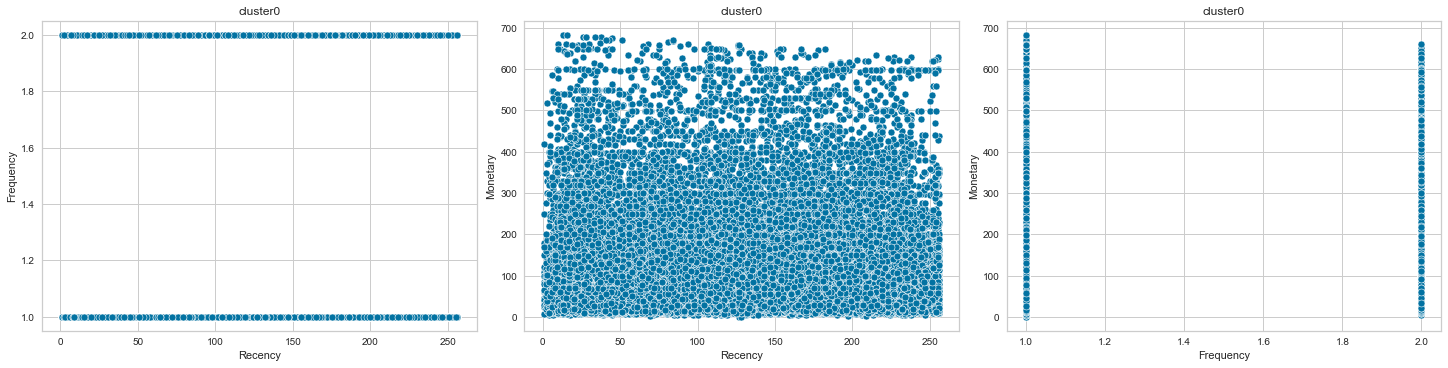

In [28]:
lists=[["Recency", "Frequency"],["Recency","Monetary"],["Frequency","Monetary"]]
fpairplot(cluster0,lists,'cluster0')

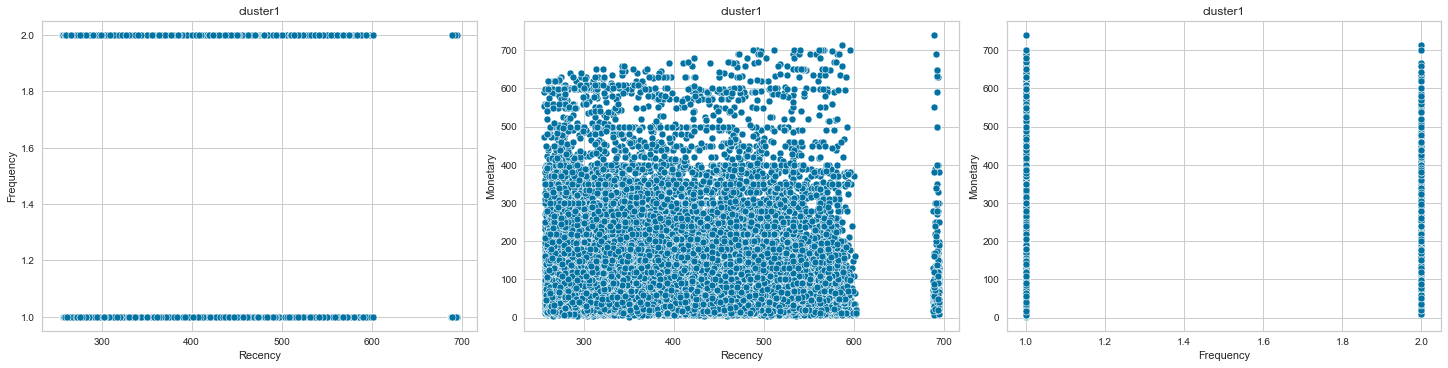

In [29]:
lists=[["Recency", "Frequency"],["Recency","Monetary"],["Frequency","Monetary"]]
fpairplot(cluster1,lists,'cluster1')

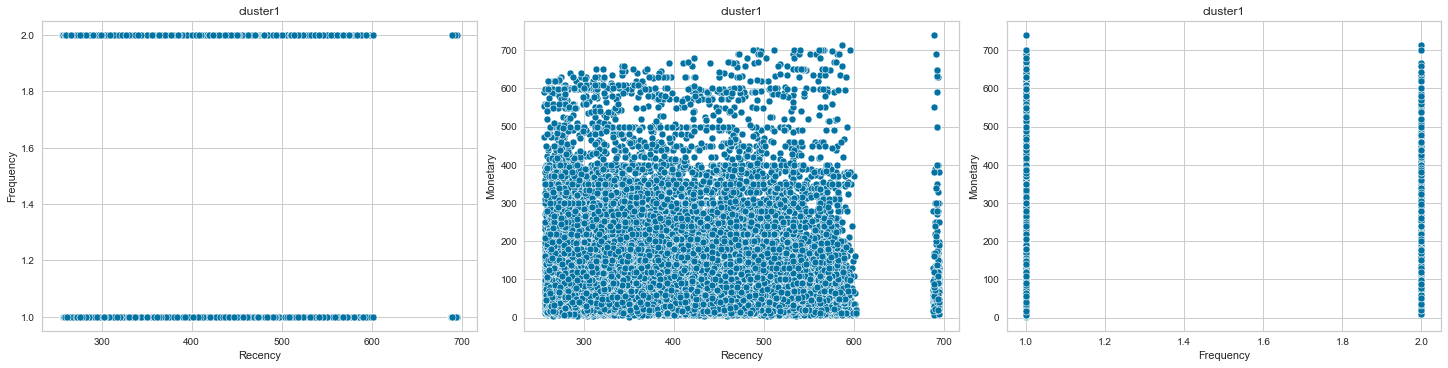

In [30]:
lists=[["Recency", "Frequency"],["Recency","Monetary"],["Frequency","Monetary"]]
fpairplot(cluster1,lists,'cluster1')

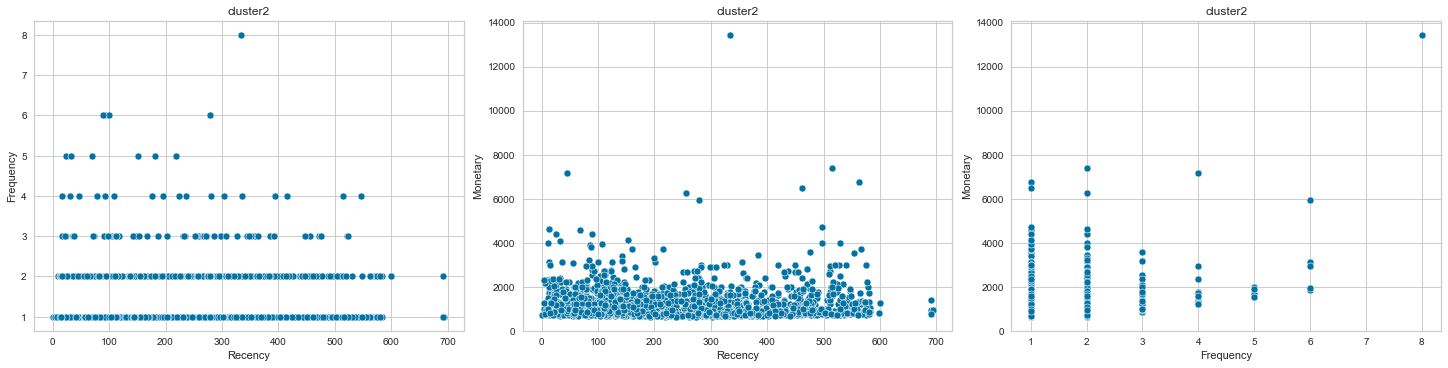

In [31]:
lists=[["Recency", "Frequency"],["Recency","Monetary"],["Frequency","Monetary"]]
fpairplot(cluster2,lists,'cluster2')

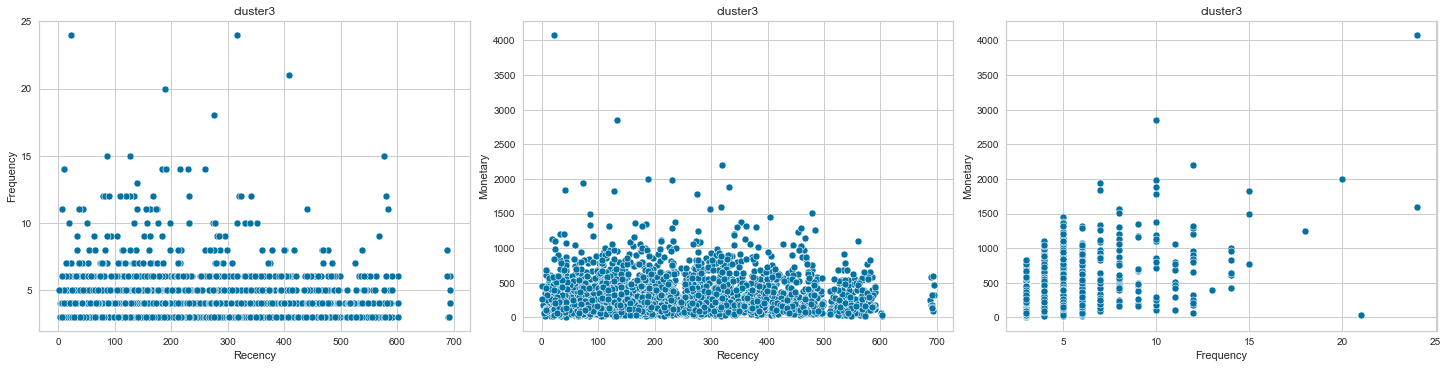

In [32]:
lists=[["Recency", "Frequency"],["Recency","Monetary"],["Frequency","Monetary"]]
fpairplot(cluster3,lists,'cluster3')

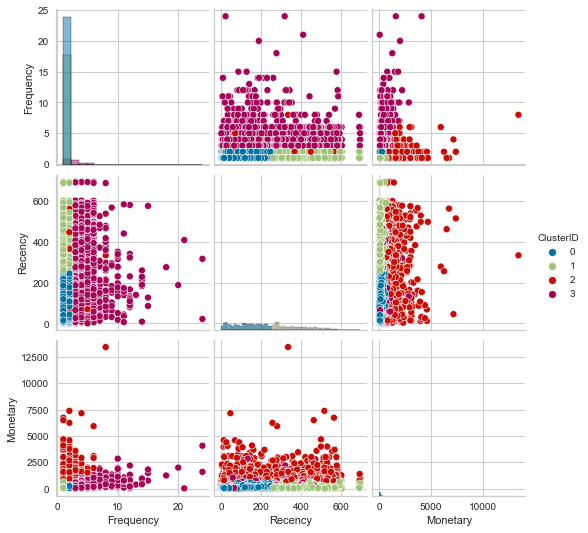

In [33]:
data=RFM_km[['ClusterID', 'Frequency',  'Recency','Monetary']]
sns.pairplot(data,hue='ClusterID', diag_kind="hist",palette=sns.color_palette(n_colors=4))

**Observations**<br>

In [34]:
km_recency_clusters=mean_clus_feat(RFM_km,'ClusterID','Recency')
km_frequency_clusters=mean_clus_feat(RFM_km,'ClusterID','Frequency')
km_monetary_clusters=mean_clus_feat(RFM_km,'ClusterID','Monetary')


In [35]:
km_recency_clusters

,Recency_mean
ClusterID,
0,126.984071
1,386.399029
2,236.316610
3,233.444480


In [36]:
km_frequency_clusters

,Frequency_mean
ClusterID,
0,1.111263
1,1.113525
2,1.263030
3,3.958239


In [37]:
km_monetary_clusters

,Monetary_mean
ClusterID,
0,114.837330
1,115.746640
2,1178.096069
3,289.112522


In [38]:
df = pd.concat([pd.Series([0,1,2,3]),km_recency_clusters, km_frequency_clusters, km_monetary_clusters], axis=1)
df.columns = ["ClusterID", "Recency_mean", "Frequency_mean", "Monetary_mean"]


In [39]:
df

,ClusterID,Recency_mean,Frequency_mean,Monetary_mean
0,0,126.984071,1.111263,114.837330
1,1,386.399029,1.113525,115.746640
2,2,236.316610,1.263030,1178.096069
3,3,233.444480,3.958239,289.112522


**Observations**<br>
-La moyenne de la récence du troisieme cluster est le plus proche de la moyenne de la récence globale(237à peu près). <br>



<AxesSubplot:xlabel='ClusterID', ylabel='Recency_mean'>

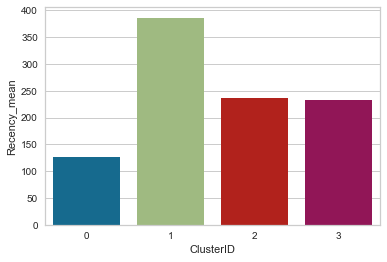

In [40]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)


**Observations**<br>
Les clients du deuxième cluster(cluster1) sont les clients qui ont les commandes les plus récentes<br>
Les clients du premier cluster(cluster0) sont les clients qui ont les commandes les plus anciennes

<AxesSubplot:xlabel='ClusterID', ylabel='Frequency_mean'>

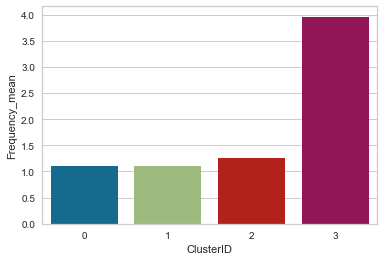

In [41]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)


**Observations**<br>
Les clients du cluster 4 (cluster3) sont les clients qui ont effectuées plusieurs commandes

<AxesSubplot:xlabel='ClusterID', ylabel='Monetary_mean'>

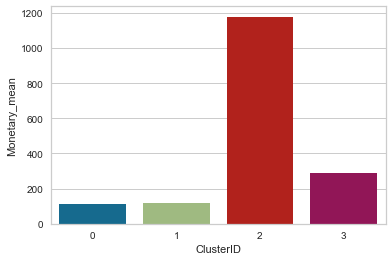

In [42]:
sns.barplot(x=df.ClusterID, y=df.Monetary_mean)

**Observations**<br>
Les clients du 3ème cluster(cluster 2) sont les clients qui ont payés le plus.
<br>


**Conclusion**<br>
2.le 1er cluster(cluster 0):clients avec des montants faibles,fréquences faibles et récences faibles<br>
2.le 2ème cluster(cluster 1):clients avec des commandes récentes<br>
2.le 3ème cluster(cluster 2):clients avec des montants élevés.<br>
1.le 4ème cluster(cluster 3): clients avec des montants élevés .<br>


#### Qualification des clusters

In [78]:
customer_types=['client  perdu','nouveau client','meilleur client','client risquant de partir']
rfm_caracte=['client  avec faible fréquence et faibles dépenses et ça fait longtemps qu\'il n\'a pas passé de commandes',
                'client récent avec faible fréquence et dépenses',
                'client fréquent et récent avec des dépenses importantes',
                'client avec faible fréquence et dépenses  et ça fait longtemps qu\'il n\'a pas passé de commandes'
               ]
d={'Cluster':list(range(0,4)),'Type de client':customer_types,'Caractéristiques RFM':rfm_caracte}

pd.set_option("display.max_colwidth", None,'display.colheader_justify', 'center')
res1=pd.DataFrame(d)

res1

,Cluster,Type de client,Caractéristiques RFM
0,0,client perdu,client avec faible fréquence et faibles dépenses et ça fait longtemps qu'il n'a pas passé de commandes
1,1,nouveau client,client récent avec faible fréquence et dépenses
2,2,meilleur client,client fréquent et récent avec des dépenses importantes
3,3,client risquant de partir,client avec faible fréquence et dépenses et ça fait longtemps qu'il n'a pas passé de commandes


### 4.Clustering avec kmeans (RFM+review_score)

<AxesSubplot:>

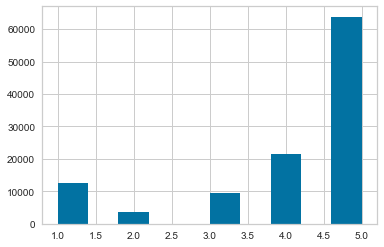

In [43]:
df_cmd['review_score'].hist()

**Observations**<br>
La plupart  desscores sont entre 4.6 et 5 

In [44]:
#scores_review_customers=df_cmd[['customer_unique_id','review_score']]
scores_review_customers=pd.DataFrame(df_cmd.groupby('customer_unique_id')['review_score'].mean())\
.rename(columns={'review_score':'review_score_mean'}).reset_index()
scores_review_customers.head()

,customer_unique_id,review_score_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0
2,0000f46a3911fa3c0805444483337064,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,4.0
4,0004aac84e0df4da2b147fca70cf8255,5.0


In [45]:
scores_review_customers.shape

(91478, 2)

<AxesSubplot:>

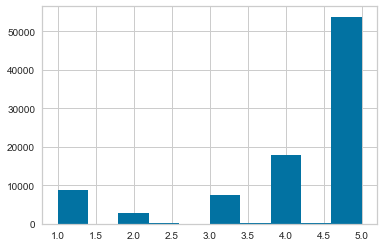

In [46]:
scores_review_customers['review_score_mean'].hist()

In [47]:
RFM.shape

(91478, 4)

In [48]:
RFM_score_review=pd.merge(RFM,scores_review_customers,on='customer_unique_id')
RFM_score_review.head()

,customer_unique_id,Frequency,Recency,Monetary,review_score_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90,4.0
2,0000f46a3911fa3c0805444483337064,1,537,69.00,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99,4.0
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00,5.0


In [49]:
RFM_score_review.shape


(91478, 5)

In [50]:
X1=RFM_score_review[['Frequency', 'Recency', 'Monetary','review_score_mean']]
Xstd1 = pd.DataFrame(scaler.fit_transform(X1), columns=X1.columns)

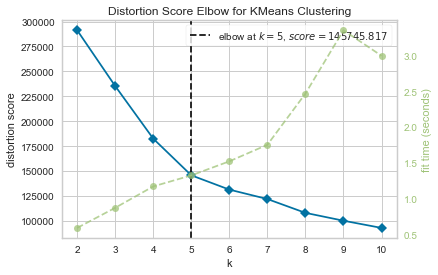

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [51]:
k_rng=range(2, 11)
visualizer = KElbowVisualizer(KMeans(init = 'k-means++', random_state = 42), k=k_rng)

visualizer.fit(Xstd1)    # Fit the data to the visualizer
visualizer.poof()


In [52]:

kmeans1 = KMeans(n_clusters = 5, init = "k-means++", random_state = 42)
y_kmeans1 = kmeans1.fit_predict(Xstd1)
y_kmeans1

array([2, 2, 0, ..., 0, 2, 0])

In [53]:
RFMS_km=pd.concat([RFM_score_review, pd.Series(y_kmeans1)], axis=1)
RFMS_km.columns = ['CustomerID', 'Frequency',  'Recency','Monetary','review_score_mean', 'ClusterID']
RFMS_km

,CustomerID,Frequency,Recency,Monetary,review_score_mean,ClusterID
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90,5.0,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90,4.0,2
2,0000f46a3911fa3c0805444483337064,1,537,69.00,3.0,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99,4.0,0
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00,5.0,0
...,...,...,...,...,...,...
91473,fffcf5a5ff07b0908bd4e2dbc735a684,2,447,1570.00,5.0,3
91474,fffea47cd6d3cc0a88bd621562a9d061,1,262,64.89,4.0,0
91475,ffff371b4d645b6ecea244b27531430a,1,568,89.90,5.0,0
91476,ffff5962728ec6157033ef9805bacc48,1,119,115.00,5.0,2


In [54]:
cust_per_clust=fnb_customper_cluster(RFMS_km)
cust_per_clust

,ClusterID,nb_customers
0,0,30863
1,1,15002
2,2,40660
3,3,1863
4,4,3090


**Observations**<br>
le cluster 3 contient le moins de clients

In [55]:
km1_recency_clusters=mean_clus_feat(RFMS_km,'ClusterID','Recency')
km1_frequency_clusters=mean_clus_feat(RFMS_km,'ClusterID','Frequency')
km1_monetary_clusters=mean_clus_feat(RFMS_km,'ClusterID','Monetary')
km1_score_clusters=mean_clus_feat(RFMS_km,'ClusterID','review_score_mean')

In [56]:
df1 = pd.concat([pd.Series([0,1,2,3,4]),km1_recency_clusters, km1_frequency_clusters, km1_monetary_clusters,km1_score_clusters], axis=1)
df1.columns = ["ClusterID", "Recency_cluster", "Frequency_cluster", "Monetary_cluster","scores_cluster"]
df1

,ClusterID,Recency_cluster,Frequency_cluster,Monetary_cluster,scores_cluster
0,0,392.591874,1.103166,116.014391,4.641739
1,1,229.701440,1.172244,124.686988,1.760432
2,2,122.124127,1.097418,113.781130,4.705903
3,3,234.043478,1.267311,1226.857654,4.162399
4,4,233.175405,3.957929,290.150544,3.654631


In [57]:
RFMS_km.describe()

,Frequency,Recency,Monetary,review_score_mean,ClusterID
count,91478.000000,91478.000000,91478.000000,91478.000000,91478.000000
mean,1.211712,237.047662,144.949038,4.154631,1.249164
std,0.679484,152.560470,220.997009,1.279228,1.051313
min,1.000000,1.000000,0.850000,1.000000,0.000000
25%,1.000000,114.000000,48.900000,4.000000,0.000000
50%,1.000000,218.000000,89.900000,5.000000,1.000000
75%,1.000000,345.000000,159.000000,5.000000,2.000000
max,24.000000,695.000000,13440.000000,5.000000,4.000000


**Observations**<br>
les scores sont pratiquement identiques dans tous les clusters

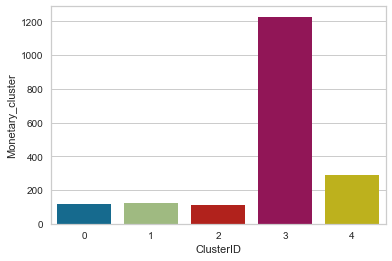

****************************************************************************************************


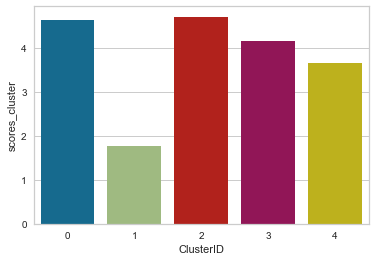

****************************************************************************************************


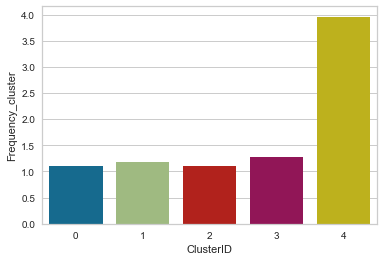

****************************************************************************************************


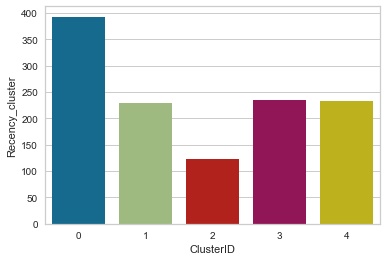

In [58]:
sns.barplot(x=df1.ClusterID, y=df1.Monetary_cluster)
plt.show()
print('*'*100)
sns.barplot(x=df1.ClusterID, y=df1.scores_cluster)
plt.show()
print('*'*100)
sns.barplot(x=df1.ClusterID, y=df1.Frequency_cluster)
plt.show()
print('*'*100)
sns.barplot(x=df1.ClusterID, y=df1.Recency_cluster)
plt.show()

**Observations**<br>
-cluster 0:les clients les plus récents et les plus satisfaits<br>
-cluster1:les clients sont les plus satisfaits<br>
-cluster2:les clients   satisfaistet <br>
-<b>cluster 3:<font color='red'>les clients avec les montants lesplus élevés, achètent fréquement et scores sont bien:poetntiel client</font>
    <br>
 -cluster4:

#### Caractérisation des clients (RFM+score)

In [70]:
customer_types2=['nouveau client satisfait',' client mécontent',' client occasionnel','potentiel client','xx']
rfm_score_caracte=['client  récents avec faible fréquence , faibles dépenses et satisfaits',
                'client récent avec faible fréquence et dépenses.pas satisfait',                
                'client avec faible fréquence et dépenses  et ça fait longtemps qu\'il n\'a pas passé de commandes mais satisfait',
                'client achète fréquement avec des dépenses importantes et satisfait',
                'clients avec une récence les montants bas , achètent fréquement et sont satistafits'
               ]
d2={'Cluster':list(range(0,5)),'Type de client':customer_types2,'Caractéristiques RFM+score':rfm_score_caracte}

pd.set_option("display.max_colwidth", None,'display.colheader_justify', 'center')
res2=pd.DataFrame(d2)
res2

,Cluster,Type de client,Caractéristiques RFM+score
0,0,nouveau client satisfait,"client récents avec faible fréquence , faibles dépenses et satisfaits"
1,1,client mécontent,client récent avec faible fréquence et dépenses.pas satisfait
2,2,client occasionnel,client avec faible fréquence et dépenses et ça fait longtemps qu'il n'a pas passé de commandes mais satisfait
3,3,potentiel client,client achète fréquement avec des dépenses importantes et satisfait
4,4,xx,"clients avec une récence les montants bas , achètent fréquement et sont satistafits"


In [59]:
df1.columns

Index(['ClusterID', 'Recency_cluster', 'Frequency_cluster', 'Monetary_cluster',
       'scores_cluster'],
      dtype='object')

### .Clustering avec kmeans (RFM+localisation)

### DBSCAN

<IPython.core.display.Javascript object>


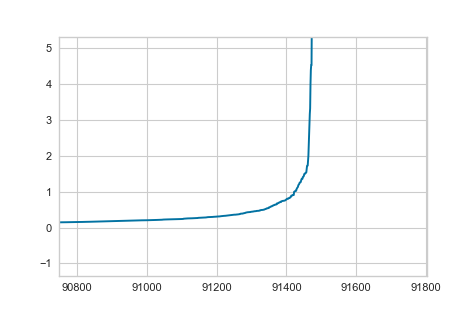

In [126]:
from sklearn.neighbors import NearestNeighbors
%matplotlib notebook
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(Xstd)
distances, indices = neighbors_fit.kneighbors(Xstd)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)

In [ ]:

from sklearn.cluster import DBSCAN
EPS=[1,1.8]
for e in EPS:
    db = DBSCAN(eps=e, min_samples=10).fit(Xstd)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print(e)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("cutomers not associated to  clusters: %d" % n_noise_)
    print('*'*100)

### .Agglomerative clustering (RFM)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
aggloclust=AgglomerativeClustering(n_clusters=5).fit(Xstd)
print(aggloclust)

### .Clustering avec kprotype (RFM+localisation)

In [46]:
from kmodes.kprototypes import KPrototypes

In [70]:
df_cmd.columns

Index(['customer_id', 'customer_unique_id', 'customer_city', 'customer_state',
       'order_id', 'order_status', 'order_purchase_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'price', 'payment_type', 'review_id',
       'review_score', 'product_category_name', 'seller_zip_code_prefix',
       'seller_city', 'seller_state'],
      dtype='object')

In [47]:
customer_loc=df_cmd[['customer_unique_id','customer_city', 'customer_state']]
customer_loc['customer_city_state']=customer_loc['customer_city'].str.upper()+customer_loc['customer_state'].str.upper()

C:\Users\IMEN\AppData\Local\Temp\ipykernel_5300\2233972235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_loc['customer_city_state']=customer_loc['customer_city'].str.upper()+customer_loc['customer_state'].str.upper()


In [72]:
customer_loc=customer_loc

In [50]:
RFM_loc=pd.merge(customer_loc,RFM,on='customer_unique_id')
RFM_loc=RFM_loc[['customer_unique_id','customer_city_state','Frequency','Monetary','Recency']]
RFM_loc

,customer_unique_id,customer_city_state,Frequency,Monetary,Recency
0,861eff4711a542e4b93843c6dd7febb0,FRANCASP,1,124.99,470
1,9eae34bbd3a474ec5d07949ca7de67c0,SANTAREMPA,2,225.98,294
2,9eae34bbd3a474ec5d07949ca7de67c0,SANTAREMPA,2,225.98,294
3,3c799d181c34d51f6d44bbbc563024db,NOVA SANTA RITARS,1,124.99,479
4,23397e992b09769faf5e66f9e171a241,MAGERJ,1,106.99,207
...,...,...,...,...,...
110840,38e482d7770a43f5929378c4dec76d5e,PARNAMIRIMRN,1,1750.00,13
110841,393c2ace23a135d0bcc7e70167448e16,BARREIRASBA,1,145.90,41
110842,5c22dbb9d8b5385953f2f1e6d9d115a7,JORDANIAMG,1,49.90,28
110843,7f5f43a9394964ac51bc5d1e0204ead4,URUACUGO,1,135.98,11


In [63]:
RFM_loc_scal = RFM_loc.copy()

RFM_loc_scal[['Frequency','Monetary','Recency']] = scaler.fit_transform(RFM_loc[['Frequency','Monetary','Recency']])

X_sca=RFM_loc_scal[['Frequency','Monetary','Recency','customer_city_state']]
X_sca

,Frequency,Monetary,Recency,customer_city_state
0,-0.406723,-0.163188,1.531656,FRANCASP
1,0.279454,0.193968,0.375360,SANTAREMPA
2,0.279454,0.193968,0.375360,SANTAREMPA
3,-0.406723,-0.163188,1.590785,NOVA SANTA RITARS
4,-0.406723,-0.226846,-0.196218,MAGERJ
...,...,...,...,...
110840,-0.406723,5.583735,-1.470771,PARNAMIRIMRN
110841,-0.406723,-0.089239,-1.286815,BARREIRASBA
110842,-0.406723,-0.428748,-1.372223,JORDANIAMG
110843,-0.406723,-0.124322,-1.483911,URUACUGO


In [64]:
#Actual clustering
kproto = KPrototypes(n_clusters=4,  init='Huang',n_jobs=-1,n_init=10,verbose=1) 
clusters = kproto.fit(X_sca, categorical=[3])


#Prints the count of each cluster group
pd.Series(clusters).value_counts()

Best run was number 7


KPrototypes(gamma=0.5, init='Huang', n_clusters=4, n_jobs=-1, verbose=1)    1
dtype: int64

In [73]:
k_rng

range(2, 11)

In [ ]:
import time
start = time.time()

felbow_kprototypes(k_rng,X_sca,3)

end = time.time()
elapsed = end - start

print(f'Temps d\'exécution : {elapsed:.2}ms')

2\.cluster start


### .Agglomerative clustering (RFM)

### DBSCAN

In [79]:
df_db=RFM.sample(frac=0.5)
df_db.head()

,customer_unique_id,Frequency,Recency,Monetary
2997,084142ff1817e56910833e3edd9bb3d5,2,261,100.00
90786,fe0617cc03bb1fdefeb9e76e7d316548,1,194,29.99
74143,cf523d0df815451719f36ad96aff8d78,1,217,169.90
78079,da2b78576894a7f95d45bfd20250cc54,3,268,374.15
5866,103d84bb2976d228f12366cdce69da76,1,74,79.90


In [ ]:
!python -V
